In [1]:
# Political Pole Detector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import nltk
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from math import sqrt
import joblib
import string
import re
import sys
import datetime
import html
import os
import timeit
nltk.download('punkt')
nltk.download('wordnet')

# sklearn=0.23.1, pandas=1.0.1
print(sklearn.__version__)
print(pd.__version__)

0.23.1
1.0.1


[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# This helps turn .txt files into Excel files .xlsx or CSV files (if you're lucky)
# If files aren't cooperative...run this code then copy and paste the dates into column one
# and articles into column two in Excel, then save as an Excel file.

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            date = line
#            date = date[0:12]
#            with open('csvs/NewsMax.txt', 'a+', encoding='utf-8') as s:
#                s.write(date + "\n")

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            article = line
#            article = article[12:]
#            with open('csvs/NewsMax2.txt', 'a+', encoding='utf-8') as s:
#                s.write(article)

In [3]:
# Let's see what features we have.

# Character length requirement for articles
length_req = 800

left1 = pd.read_excel("csvs/Huffington.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left1.shape[0]))

for x in range(left1.shape[0]):
    if len(left1['article'][x]) < length_req:
        left1.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left1.shape[0], length_req))

# Only keep the unique article rows and their values
left1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left1.shape[0]))

left1['date'] = left1['date'].str.replace(',', '')

left1.head()

We have 4,355 left-wing records
We have 4,314 left-wing records > 800 characters long
4,304 Records are unique


,date,article
0,2020-01-01,"Elizabeth Warren Rips ‘Fawning, Spineless’ Rep..."
1,2020-01-01,These Major New Laws Take Effect Today From ma...
2,2020-01-01,U.S. To Deploy Hundreds Of Troops To Iraq Afte...
3,2020-01-01,Police And Protesters Clash In New Year’s Rall...
4,2020-01-01,Trump Shrugs Off Kim Jong Un’s Nuclear Testing...


In [4]:
left2 = pd.read_excel("csvs/Salon.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left2.shape[0]))

left2['date'].fillna("", inplace=True)
left2['article'].fillna("", inplace=True)

for x in range(left2.shape[0]):
    if len(left2['article'][x]) < length_req:
        left2.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left2.shape[0], length_req))

# Only keep the unique article rows and their values
left2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left2.shape[0]))

left2['date'] = left2['date'].str.replace(',', '')

left2.head()

We have 2,303 left-wing records
We have 2,278 left-wing records > 800 characters long
1,987 Records are unique


,date,article
0,2020-01-15,"Lev Parnas, the indicted associate of former N..."
1,2020-01-26,President Donald Trump's comments about Thomas...
2,2020-05-31,This article originally appeared at Common Dre...
3,2020-05-31,Trump admin rush migrant children deportations...
4,2020-05-31,"The late Gore Vidal once confessed, with chara..."


In [5]:
left3 = pd.read_excel("csvs/Rawstory.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left3.shape[0]))

for x in range(left3.shape[0]):
    if len(left3['article'][x]) < length_req:
        left3.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left3.shape[0], length_req))

# Only keep the unique article rows and their values
left3.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left3.shape[0]))

left3['date'] = left3['date'].str.replace(',', '')

left3.head()

We have 1,160 left-wing records
We have 1,159 left-wing records > 800 characters long
1,159 Records are unique


,date,article
0,2020-01-15,‘Uninterested in evidence’: Embattled Susan Co...
1,2020-02-07,Tornado warning issued for 2 New Jersey counti...
2,2020-02-07,Trump official busted for telling ‘blatant lie...
3,2020-02-07,Republicans face ‘Electoral College time bomb’...
4,2020-02-07,We’re a former coal company and we support gov...


In [6]:
left_min = [left1.shape[0], left2.shape[0], left3.shape[0]]
left_min_entries = min(left_min)

left1 = left1.sample(left_min_entries)
left2 = left2.sample(left_min_entries)
left3 = left3.sample(left_min_entries)

print("Huffpost: {} entries".format(left1.shape[0]))
print("Salon: {} entries".format(left2.shape[0]))
print("Rawstory: {} entries".format(left3.shape[0]))

Huffpost: 1159 entries
Salon: 1159 entries
Rawstory: 1159 entries


In [7]:
left = pd.concat([left1, left2, left3])
print("We have {:,} left-wing records".format(left.shape[0]))

We have 3,477 left-wing records


In [8]:
# Let's see what features we have.
right1 = pd.read_excel("csvs/NewsMax.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right1.shape[0]))

#count = right.shape[0]

for x in range(right1.shape[0]):
    if len(right1['article'][x]) < length_req:
        right1.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right1.shape[0], length_req))

# Only keep the unique rows and their values
right1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right1.shape[0]))

right1['date'] = right1['date'].str.replace(',', '')

right1.head()

We have 5,829 right-wing records
We have 5,637 right-wing records > 800 characters long
5,588 Records are unique


,date,article
0,2020-01-01,Klobuchar Hits Trump's Golf: 'I Spent 0 Days' ...
1,2020-01-01,WashPost: Bloomberg's China Ties Are Conflict ...
2,2020-01-01,James Woolsey to Newsmax TV: Target the IRGC N...
3,2020-01-01,Report: US Service Members Killed in Afghanist...
4,2020-01-01,Bernie Kerik to Newsmax TV: Trump Sends World ...


In [9]:
right2 = pd.read_excel("csvs/Redstate.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right2.shape[0]))

#count = right.shape[0]

for x in range(right2.shape[0]):
    if len(right2['article'][x]) < length_req:
        right2.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right2.shape[0], length_req))

# Only keep the unique rows and their values
right2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right2.shape[0]))

right2['date'] = right2['date'].str.replace(',', '')

right2.head()

We have 2,270 right-wing records
We have 2,207 right-wing records > 800 characters long
2,111 Records are unique


,date,article
0,2020-01-15,Even CNN Calls Out Democrats For How They Cele...
1,2020-01-26,The Isolation of Connectivity Image by Thom...
2,2020-05-29,Mayor of Minneapolis Lets Rioters Burn Down Po...
3,2020-05-29,Watch: CNN Crew Arrested by MN State Police Li...
4,2020-05-31,Buffalo Mayor Has Best Response to Rioter Who ...


In [10]:
right3 = pd.read_excel("csvs/WashingtonExaminer.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right3.shape[0]))

#count = right.shape[0]

for x in range(right3.shape[0]):
    if len(right3['article'][x]) < length_req:
        right3.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right3.shape[0], length_req))

# Only keep the unique rows and their values
right3.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right3.shape[0]))

right3['date'] = right3['date'].str.replace(',', '')

right3.head()

We have 1,117 right-wing records
We have 1,104 right-wing records > 800 characters long
983 Records are unique


,date,article
0,2020-01-16,'No one's giggling around here': Democrats def...
1,2020-02-19,Bloomberg would sell business and financial in...
2,2020-02-19,Uncertainty reigns over Democratic presidentia...
3,2020-02-19,Five things to watch in the Nevada Democratic ...
4,2020-02-19,'Some guy wearing a dress': Bloomberg once cal...


In [11]:
right_min = [right1.shape[0], right2.shape[0], right3.shape[0]]
right_min_entries = min(right_min)

right1 = right1.sample(right_min_entries)
right2 = right2.sample(right_min_entries)
right3 = right3.sample(right_min_entries)

print("NewsMax: {} entries".format(right1.shape[0]))
print("Redstate: {} entries".format(right2.shape[0]))
print("WashingtonExaminer: {} entries".format(right3.shape[0]))

NewsMax: 983 entries
Redstate: 983 entries
WashingtonExaminer: 983 entries


In [12]:
right = pd.concat([right1, right2, right3])
print("We have {:,} right-wing records".format(right.shape[0]))

We have 2,949 right-wing records


In [13]:
# Check for null values
right.isnull().sum(axis=0)

date       1
article    0
dtype: int64

In [14]:
left.isnull().sum(axis=0)

date       9
article    0
dtype: int64

In [15]:
# If there were null values, the below will replace them.
left['date'].fillna("", inplace=True)
right['date'].fillna("", inplace=True)
#right['article'].fillna("", inplace=True)
#right.isnull().sum(axis=0)

In [16]:
# Search for non-null valued rows
# Useful for fixing when data went into three or more columns instead of two in the Excel sheet.
#left[left['date'].notnull()]
#right[right['date'].notnull()]

# Finds all null valued rows
left[~left['date'].notnull()]
#right[~right['date'].notnull()]

,date,article


In [17]:
left['pole'] = 0  # Make a column 'pole', assign a value of 0 to indicate left articles
print("We have {:,} left-wing records".format(left.shape[0]))
right['pole'] = 1
print("We have {:,} right-wing records".format(right.shape[0]))

if (right.shape[0] > left.shape[0]):
    print("Getting random sample of right-wing records")
    right = right.sample(left.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)
else:
    print("Getting random sample of left-wing records")
    left = left.sample(right.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)
    
all_data = pd.concat([left, right]) # combine left and right datasets
column_names = all_data.columns.values
all_data.columns = column_names
all_data = all_data.sample(frac=1).reset_index(drop=True) # randomly shuffle your rows
all_data['date'] = all_data['date'].str.replace(',', '')
all_data.head()

We have 3,477 left-wing records
We have 2,949 right-wing records
Getting random sample of left-wing records


,date,article,pole
0,2020-04-16,OPINION: Shut The Freezer And Get Back To Work...,1
1,2020-06-09,CBO Lauds Trump Admin for Rapid Stimulus Deliv...,1
2,2020-06-15,John Cleese Mocks Fox News For Confusing Monty...,0
3,2020-03-10,Brutal Wall Street Journal op-ed blasts Trump ...,0
4,2020-07-13,Dems Push Immigration Reform as Top Priority f...,1


In [18]:
print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

# Only keep the unique rows and their values
all_data.drop_duplicates("article", keep=False, inplace=True)
print("{:,} Records are unique".format(
    all_data.shape[0]))

print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

2,949 / 5,898 Current Records
5,898 Records are unique
2,949 / 5,898 Current Records


In [19]:
# Save the rows used from notspam to a CSV.
# Can give you a good idea of what constitutes a good set of data
# when a run results in high accuracy.
#notspam.to_csv(r'positive.csv')
#spam.to_csv(r'negative.csv')

# We can see there's some strange html characters present.
# Very important to cast the entire column as a string type first, so some of these numeric values come in as strings.
# Otherwise, the row values for these comments where they're present will turn into NaN values.
#all_data['article'] = all_data['article'].astype(str).str.replace(r'&#39;', "\'").astype('string')

# This is a more clean and thorough url decoding function for decoding any character string...
all_data['article'] = all_data['article'].astype(str).apply(lambda x: html.unescape(x))

In [20]:
# Store the original comments in a new column
all_data['unfiltered_articles'] = all_data['article'].values
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-04-16,OPINION: Shut The Freezer And Get Back To Work...,1,OPINION: Shut The Freezer And Get Back To Work...
1,2020-06-09,CBO Lauds Trump Admin for Rapid Stimulus Deliv...,1,CBO Lauds Trump Admin for Rapid Stimulus Deliv...
2,2020-06-15,John Cleese Mocks Fox News For Confusing Monty...,0,John Cleese Mocks Fox News For Confusing Monty...
3,2020-03-10,Brutal Wall Street Journal op-ed blasts Trump ...,0,Brutal Wall Street Journal op-ed blasts Trump ...
4,2020-07-13,Dems Push Immigration Reform as Top Priority f...,1,Dems Push Immigration Reform as Top Priority f...


In [21]:
# Clean the text
# The apostrophes here are very specific.
# The regular ' will not work from keyboard.
# You have to use print(all_data.head()) and copy and paste that apostrophe into the str.replace()
all_data['article'] = all_data['article'].str.lower()
all_data['article'] = all_data['article'].str.replace(r"u.s.", "united states")
all_data['article'] = all_data['article'].str.replace(r"what’s", "what is")
all_data['article'] = all_data['article'].str.replace(r"’s", " ")
all_data['article'] = all_data['article'].str.replace(r"’ve", "have")
all_data['article'] = all_data['article'].str.replace(r"’re", "are")
all_data['article'] = all_data['article'].str.replace(r"’ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can’t", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren’t", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn’t", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn’t", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn’t", "does not")
all_data['article'] = all_data['article'].str.replace(r"don’t", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn’t", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn’t", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven’t", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn’t", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn’t", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn’t", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren’t", "were not")
all_data['article'] = all_data['article'].str.replace(r"won’t", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn’t", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn’t", "must not")
all_data['article'] = all_data['article'].str.replace(r"i’m", "i am")

# As are these apostrophes...
all_data['article'] = all_data['article'].str.replace(r"what's", "what is")
all_data['article'] = all_data['article'].str.replace(r"'s", " ")
all_data['article'] = all_data['article'].str.replace(r"'ve", "have")
all_data['article'] = all_data['article'].str.replace(r"'re", "are")
all_data['article'] = all_data['article'].str.replace(r"'ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can't", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren't", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn't", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn't", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn't", "does not")
all_data['article'] = all_data['article'].str.replace(r"don't", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn't", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn't", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven't", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn't", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn't", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn't", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren't", "were not")
all_data['article'] = all_data['article'].str.replace(r"won't", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn't", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn't", "must not")
all_data['article'] = all_data['article'].str.replace(r"i'm", "i am")
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-04-16,opinion: shut the freezer and get back to work...,1,OPINION: Shut The Freezer And Get Back To Work...
1,2020-06-09,cbo launited statestrump admin for rapid stimu...,1,CBO Lauds Trump Admin for Rapid Stimulus Deliv...
2,2020-06-15,john cleese mocks fox news for confusing monty...,0,John Cleese Mocks Fox News For Confusing Monty...
3,2020-03-10,brutal wall street journal op-ed blasts trump ...,0,Brutal Wall Street Journal op-ed blasts Trump ...
4,2020-07-13,dems push immigration reform as top priority f...,1,Dems Push Immigration Reform as Top Priority f...


In [22]:
# Custom word removal - these appear too frequently and do not help with generalization.
custom = {'donald j trump', 'donald john trump', 'donald j. trump', 'newsmax', 'redstate', 'washingtonexaminer', 'washington examiner', 
          "huffpost", 'salon', 'rawstory', 'raw story',
          "___", "donald trump", "trump", "pelosi"}

# Did not work
#for word in custom:
#    all_data["article"]= all_data["article"].replace(word, " ") 

# Did not work
#all_data['article'] = all_data['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom)]))

# Did work
#def customWord(text):
#    custom = {'donald j trump', 'donald john trump', 'donald j. trump', "huffpost", "newsmax"}
#    return text.replace("huffpost", " ") 

for word in custom:
    all_data['article'] = all_data['article'].apply(lambda x: x.replace(word, " "))
    
# Check to see the words were replaced
all_data[all_data['article'].str.contains("newsmax")]

,date,article,pole,unfiltered_articles


In [23]:
# Remove years and digits from being used as features
def remove_years(text):
    text = re.sub(r"[0-9]{4}", " ", text)
    text = re.sub(r"[0-9]{3}", " ", text)
    text = re.sub(r"[0-9]{2}", " ", text)
    text = re.sub(r"[0-9]{1}", " ", text)
    text = re.sub(r"[0-9]{4}ish", " ", text)
    text = re.sub(r"[0-9]{3}ish", " ", text)
    text = re.sub(r"[0-9]{2}ish", " ", text)
    text = re.sub(r"[0-9]{1}ish", " ", text)
    text = re.sub(r"2020-[0-9]{2}-[0-9]{2}", " ", text)
    return text

all_data['article'] = all_data['article'].apply(lambda x: remove_years(x))
all_data.head()

# Punctuation removal - CountVectorizer() does this for you
#punctuation = {'.', ':', ';', "\'", '\"', '!', '?', "\’", '(', ')', '-'}

,date,article,pole,unfiltered_articles
0,2020-04-16,opinion: shut the freezer and get back to work...,1,OPINION: Shut The Freezer And Get Back To Work...
1,2020-06-09,cbo launited states admin for rapid stimulus ...,1,CBO Lauds Trump Admin for Rapid Stimulus Deliv...
2,2020-06-15,john cleese mocks fox news for confusing monty...,0,John Cleese Mocks Fox News For Confusing Monty...
3,2020-03-10,brutal wall street journal op-ed blasts for ...,0,Brutal Wall Street Journal op-ed blasts Trump ...
4,2020-07-13,dems push immigration reform as top priority f...,1,Dems Push Immigration Reform as Top Priority f...


In [24]:
all_data[all_data['article'].str.contains("19")]

,date,article,pole,unfiltered_articles


### One-gram - Stopword removal and no lemmatization

In [25]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the classifier over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.840763
752663.4329000001ms
Confusion Matrix:
[[487 107]
 [ 83 503]]
Accuracy Score : 0.8389830508474576
Report : 
              precision    recall  f1-score   support

        Left       0.85      0.82      0.84       594
       Right       0.82      0.86      0.84       586

    accuracy                           0.84      1180
   macro avg       0.84      0.84      0.84      1180
weighted avg       0.84      0.84      0.84      1180

Logistic Regression Accuracy Score averaged over 30 runs: 0.856384
407099.8098ms
Confusion Matrix:
[[479  86]
 [ 75 540]]
Accuracy Score : 0.8635593220338983
Report : 
              precision    recall  f1-score   support

        Left       0.86      0.85      0.86       565
       Right       0.86      0.88      0.87       615

    accuracy                           0.86      1180
   macro avg       0.86      0.86      0.86      1180
weighted avg       0.86      0.86      0.86      1180

LinearSVC Accu

### Voteclassifier - Stopword removal and no lemmatization

In [26]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.880395
865058.1473999996ms
Confusion Matrix:
[[504  91]
 [ 62 523]]
Accuracy Score : 0.8703389830508474
Report : 
              precision    recall  f1-score   support

        Left       0.89      0.85      0.87       595
       Right       0.85      0.89      0.87       585

    accuracy                           0.87      1180
   macro avg       0.87      0.87      0.87      1180
weighted avg       0.87      0.87      0.87      1180



In [27]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [28]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [29]:
# Let's save our model
joblib.dump(text_clf, 'hsr_and_nrw_onegram_sr_nol_nopr.pkl')

['hsr_and_nrw_onegram_sr_nol_nopr.pkl']

### Bi-gram - Stopword removal and no lemmatization

In [30]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.849548
824920.4576000002ms
Confusion Matrix:
[[487  93]
 [ 64 536]]
Accuracy Score : 0.8669491525423729
Report : 
              precision    recall  f1-score   support

        Left       0.88      0.84      0.86       580
       Right       0.85      0.89      0.87       600

    accuracy                           0.87      1180
   macro avg       0.87      0.87      0.87      1180
weighted avg       0.87      0.87      0.87      1180

Logistic Regression Accuracy Score averaged over 30 runs: 0.861412
546577.9845000006ms
Confusion Matrix:
[[477 104]
 [ 51 548]]
Accuracy Score : 0.8686440677966102
Report : 
              precision    recall  f1-score   support

        Left       0.90      0.82      0.86       581
       Right       0.84      0.91      0.88       599

    accuracy                           0.87      1180
   macro avg       0.87      0.87      0.87      1180
weighted avg       0.87      0.87      0.87      1180

LinearSV

### Voteclassifier - Stopword removal and no lemmatization

In [31]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.885819
1333369.8750999994ms
Confusion Matrix:
[[490  69]
 [ 67 554]]
Accuracy Score : 0.8847457627118644
Report : 
              precision    recall  f1-score   support

        Left       0.88      0.88      0.88       559
       Right       0.89      0.89      0.89       621

    accuracy                           0.88      1180
   macro avg       0.88      0.88      0.88      1180
weighted avg       0.88      0.88      0.88      1180



In [32]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [33]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [34]:
# Let's save our model
joblib.dump(text_clf, 'hsr_and_nrw_bigram_sr_nol_nopr.pkl')

['hsr_and_nrw_bigram_sr_nol_nopr.pkl']

### Tri-gram - Stopword removal and no lemmatization

In [35]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.849689
1295048.7685999996ms
Confusion Matrix:
[[501 101]
 [ 76 502]]
Accuracy Score : 0.85
Report : 
              precision    recall  f1-score   support

        Left       0.87      0.83      0.85       602
       Right       0.83      0.87      0.85       578

    accuracy                           0.85      1180
   macro avg       0.85      0.85      0.85      1180
weighted avg       0.85      0.85      0.85      1180

Logistic Regression Accuracy Score averaged over 30 runs: 0.863559
842796.3858000003ms
Confusion Matrix:
[[477 100]
 [ 59 544]]
Accuracy Score : 0.8652542372881356
Report : 
              precision    recall  f1-score   support

        Left       0.89      0.83      0.86       577
       Right       0.84      0.90      0.87       603

    accuracy                           0.87      1180
   macro avg       0.87      0.86      0.86      1180
weighted avg       0.87      0.87      0.86      1180

LinearSVC Accuracy Sc

### Voteclassifier - Stopword removal and no lemmatization

In [36]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.883475
1400841.5625999987ms
Confusion Matrix:
[[523  65]
 [ 57 535]]
Accuracy Score : 0.8966101694915254
Report : 
              precision    recall  f1-score   support

        Left       0.90      0.89      0.90       588
       Right       0.89      0.90      0.90       592

    accuracy                           0.90      1180
   macro avg       0.90      0.90      0.90      1180
weighted avg       0.90      0.90      0.90      1180



In [37]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [38]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [39]:
# Let's save our model
joblib.dump(text_clf, 'hsr_and_nrw_trigram_sr_nol_nopr.pkl')

['hsr_and_nrw_trigram_sr_nol_nopr.pkl']

In [40]:
# Lemmatization after Word Tokenization
# Higher accuracy and recall consistently resulted from no lemmatization as opposed to lemmatization.
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

lemmatizer = WordNetLemmatizer()
all_data['article'] = all_data.article.apply(lemmatize_text)
all_data.head()

# Turn the list of tokens back into a sentence
all_data['article'] = [' '.join(comment) for comment in all_data['article']]
all_data.head()

,date,article,pole,unfiltered_articles
2972,2020-04-16,white house counited stateslor kellyanne conwa...,0,White House counselor Kellyanne Conway lashed ...
5675,2020-03-10,vatican close st. peter basilica to tourist ov...,0,Vatican Closes St. Peter’s Basilica To Tourist...
3054,2020-01-26,doug collins : 'facts and the truth ' on side ...,1,Doug Collins: 'Facts and the Truth' on Trump's...
1385,2020-07-27,espn radio host who previously dunked on ha an...,1,ESPN Radio Host Who Previously Dunked on Trump...
2759,2020-04-07,say ‘ nobody ’ knew pandemic wa coming . his a...,0,Trump Says ‘Nobody’ Knew Pandemic Was Coming. ...


### One-gram - Stopword removal and lemmatization

In [41]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.829266
638172.262600001ms
Confusion Matrix:
[[488  94]
 [ 93 505]]
Accuracy Score : 0.8415254237288136
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.84      0.84       582
       Right       0.84      0.84      0.84       598

    accuracy                           0.84      1180
   macro avg       0.84      0.84      0.84      1180
weighted avg       0.84      0.84      0.84      1180

Logistic Regression Accuracy Score averaged over 30 runs: 0.846638
322887.2923000017ms
Confusion Matrix:
[[489 106]
 [ 59 526]]
Accuracy Score : 0.8601694915254238
Report : 
              precision    recall  f1-score   support

        Left       0.89      0.82      0.86       595
       Right       0.83      0.90      0.86       585

    accuracy                           0.86      1180
   macro avg       0.86      0.86      0.86      1180
weighted avg       0.86      0.86      0.86      1180

LinearSVC

### Voteclassifier - Stopword removal and lemmatization

In [42]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.870593
867062.2880999981ms
Confusion Matrix:
[[532  69]
 [ 74 505]]
Accuracy Score : 0.8788135593220339
Report : 
              precision    recall  f1-score   support

        Left       0.88      0.89      0.88       601
       Right       0.88      0.87      0.88       579

    accuracy                           0.88      1180
   macro avg       0.88      0.88      0.88      1180
weighted avg       0.88      0.88      0.88      1180



In [43]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [44]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [45]:
# Let's save our model
joblib.dump(text_clf, 'hsr_and_nrw_onegram_sr_l_nopr.pkl')

['hsr_and_nrw_onegram_sr_l_nopr.pkl']

### Bi-gram - Stopword removal and lemmatization

In [46]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.837938
870076.5498999972ms
Confusion Matrix:
[[468 108]
 [106 498]]
Accuracy Score : 0.8186440677966101
Report : 
              precision    recall  f1-score   support

        Left       0.82      0.81      0.81       576
       Right       0.82      0.82      0.82       604

    accuracy                           0.82      1180
   macro avg       0.82      0.82      0.82      1180
weighted avg       0.82      0.82      0.82      1180

Logistic Regression Accuracy Score averaged over 30 runs: 0.855904
631828.4311000025ms
Confusion Matrix:
[[468 111]
 [ 61 540]]
Accuracy Score : 0.8542372881355932
Report : 
              precision    recall  f1-score   support

        Left       0.88      0.81      0.84       579
       Right       0.83      0.90      0.86       601

    accuracy                           0.85      1180
   macro avg       0.86      0.85      0.85      1180
weighted avg       0.86      0.85      0.85      1180

LinearSV

### Voteclassifier - Stopword removal and lemmatization

In [47]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.881243
1130313.6150999998ms
Confusion Matrix:
[[515  74]
 [ 57 534]]
Accuracy Score : 0.8889830508474577
Report : 
              precision    recall  f1-score   support

        Left       0.90      0.87      0.89       589
       Right       0.88      0.90      0.89       591

    accuracy                           0.89      1180
   macro avg       0.89      0.89      0.89      1180
weighted avg       0.89      0.89      0.89      1180



In [48]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [49]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [50]:
# Let's save our model
joblib.dump(text_clf, 'hsr_and_nrw_bigram_sr_l_nopr.pkl')

['hsr_and_nrw_bigram_sr_l_nopr.pkl']

### Tri-gram - Stopword removal and lemmatization

In [51]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.840537
1313895.237599998ms
Confusion Matrix:
[[477 115]
 [ 83 505]]
Accuracy Score : 0.8322033898305085
Report : 
              precision    recall  f1-score   support

        Left       0.85      0.81      0.83       592
       Right       0.81      0.86      0.84       588

    accuracy                           0.83      1180
   macro avg       0.83      0.83      0.83      1180
weighted avg       0.83      0.83      0.83      1180

Logistic Regression Accuracy Score averaged over 30 runs: 0.855791
989856.5733999967ms
Confusion Matrix:
[[446 129]
 [ 58 547]]
Accuracy Score : 0.8415254237288136
Report : 
              precision    recall  f1-score   support

        Left       0.88      0.78      0.83       575
       Right       0.81      0.90      0.85       605

    accuracy                           0.84      1180
   macro avg       0.85      0.84      0.84      1180
weighted avg       0.85      0.84      0.84      1180

LinearSV

### Voteclassifier - Stopword removal and lemmatization

In [52]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.877797
1874880.1180999945ms
Confusion Matrix:
[[504  77]
 [ 58 541]]
Accuracy Score : 0.885593220338983
Report : 
              precision    recall  f1-score   support

        Left       0.90      0.87      0.88       581
       Right       0.88      0.90      0.89       599

    accuracy                           0.89      1180
   macro avg       0.89      0.89      0.89      1180
weighted avg       0.89      0.89      0.89      1180



In [53]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [54]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [55]:
# Let's save our model
joblib.dump(text_clf, 'hsr_and_nrw_trigram_sr_l_nopr.pkl')

['hsr_and_nrw_trigram_sr_l_nopr.pkl']

In [56]:
# This just makes sure the below functions work for seeing
# words that are used as features to detect spam comments.
# It does not retrain the model. That was saved in final_model.
train, test = train_test_split(all_data, test_size=0.2)

# Changing this to n_gram(1,2) may be all you need to do to see some of the top bigrams.
count_vect = CountVectorizer(min_df = 4, max_df = .75, stop_words='english', ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(train.article)
X_train_counts.shape

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

clf = SGDClassifier().fit(X_train_tfidf, train.pole)

In [57]:
# Shows you the most frequently occurring words seen in text labelled as left or right
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1]) 
    print("\t\t%-15s\t\t\t%-15s" % ('Left', 'Right'))
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
show_most_informative_features(count_vect, clf, 40)

		Left           			Right          
	-6.3660	donald         		2.8979	democrat       
	-3.8813	president donald		2.1057	healthcare     
	-2.9522	appeared       		2.0094	left           
	-2.9376	originally appeared		1.9204	wuhan          
	-2.9270	article originally		1.7289	aoc            
	-2.9270	article originally appeared		1.7232	medium         
	-2.4243	originally     		1.6577	dems           
	-2.3552	covid          		1.5340	china          
	-2.2798	host           		1.4517	biden          
	-2.1625	claimed        		1.4343	dnc            
	-2.1328	article        		1.4180	piece          
	-2.0769	writer         		1.4057	chairman       
	-2.0095	progressive    		1.3244	alex           
	-1.8730	asked          		1.3010	vermont        
	-1.7526	video          		1.2825	schumer        
	-1.7340	twitter        		1.2808	ap photo       
	-1.7002	argued         		1.2622	riot           
	-1.6933	social security		1.2374	hot            
	-1.6912	right          		1.2350	bipartisan     
	-1.6458	new 

In [58]:
# Shows you the most frequently occurring words seen in text labelled as right.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['right'], 50)

right: bolling, push, committee, comment came, griffin, running, ferrer, headline, sharpton, hill, border, according hill, rally, mccabe, ch, prepared, scott, communist, wuhan virus, sentence, illinois, rioting, told fox, woke, july, american people, mob, following, death george, death george floyd, rioter, bipartisan, hot, riot, ap photo, schumer, vermont, alex, chairman, piece, dnc, biden, china, dems, medium, aoc, wuhan, left, healthcare, democrat


In [59]:
# Shows you the most frequently occurring words seen in text labelled as left.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[:n]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['left'], 50)

left: donald, president donald, appeared, originally appeared, article originally appeared, article originally, originally, covid, host, claimed, article, writer, progressive, asked, video, twitter, argued, social security, right, new, reportedly, warned, wednesday, repeatedly, right wing, month, ceremony, check, column, editorial, fec, disease, footage, kind, sunday, voting, twitter user, people, pandemic, disability, later, washington ap, check clip, nationwide, social, worker, amash, anti, explained, ky


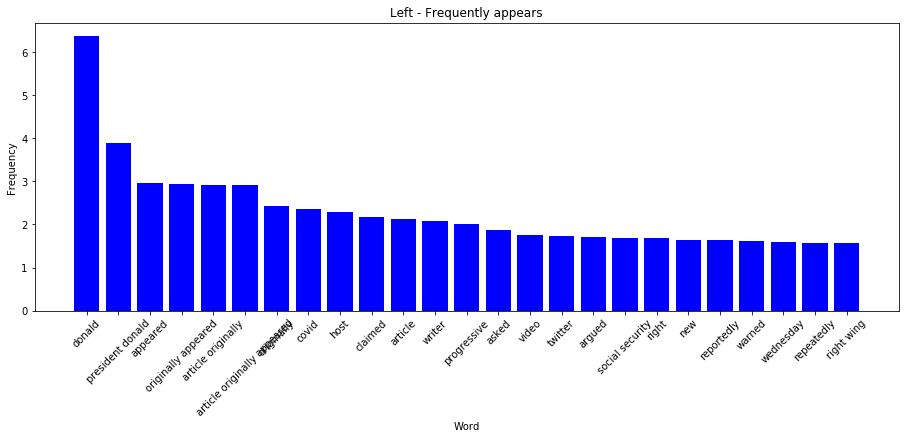

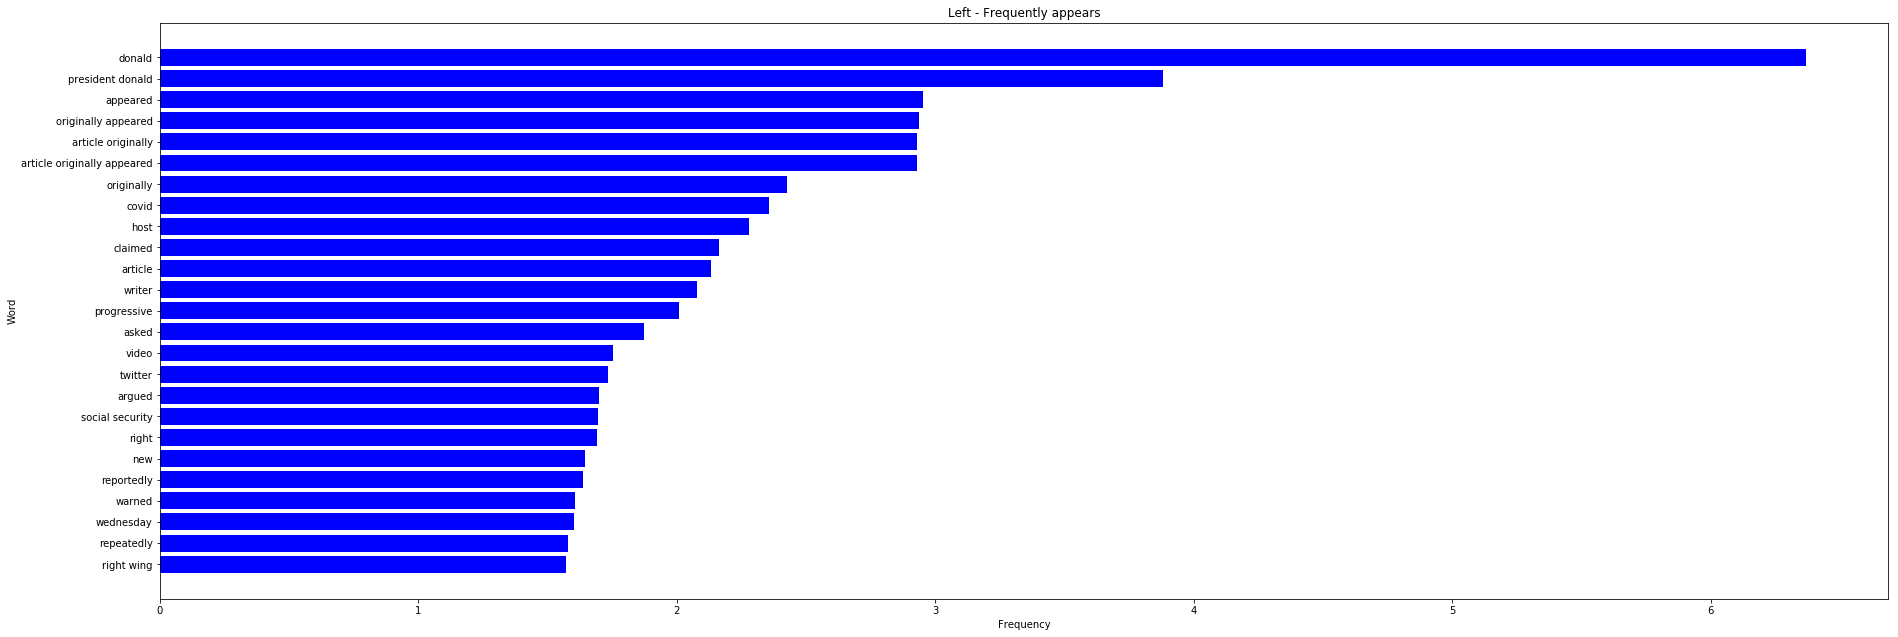

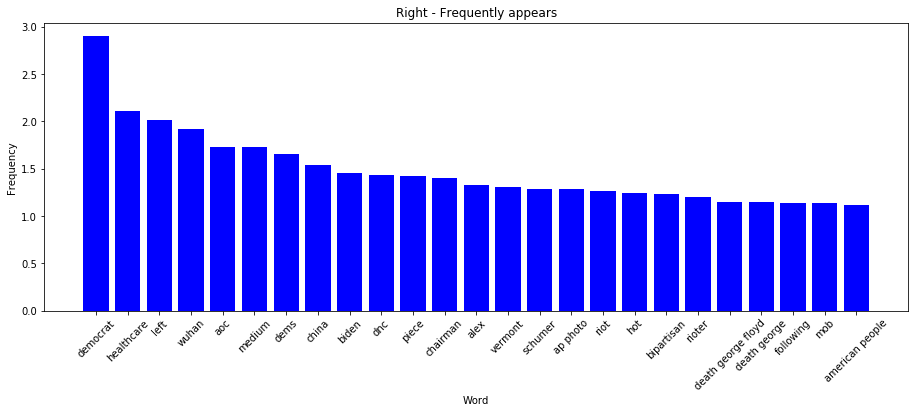

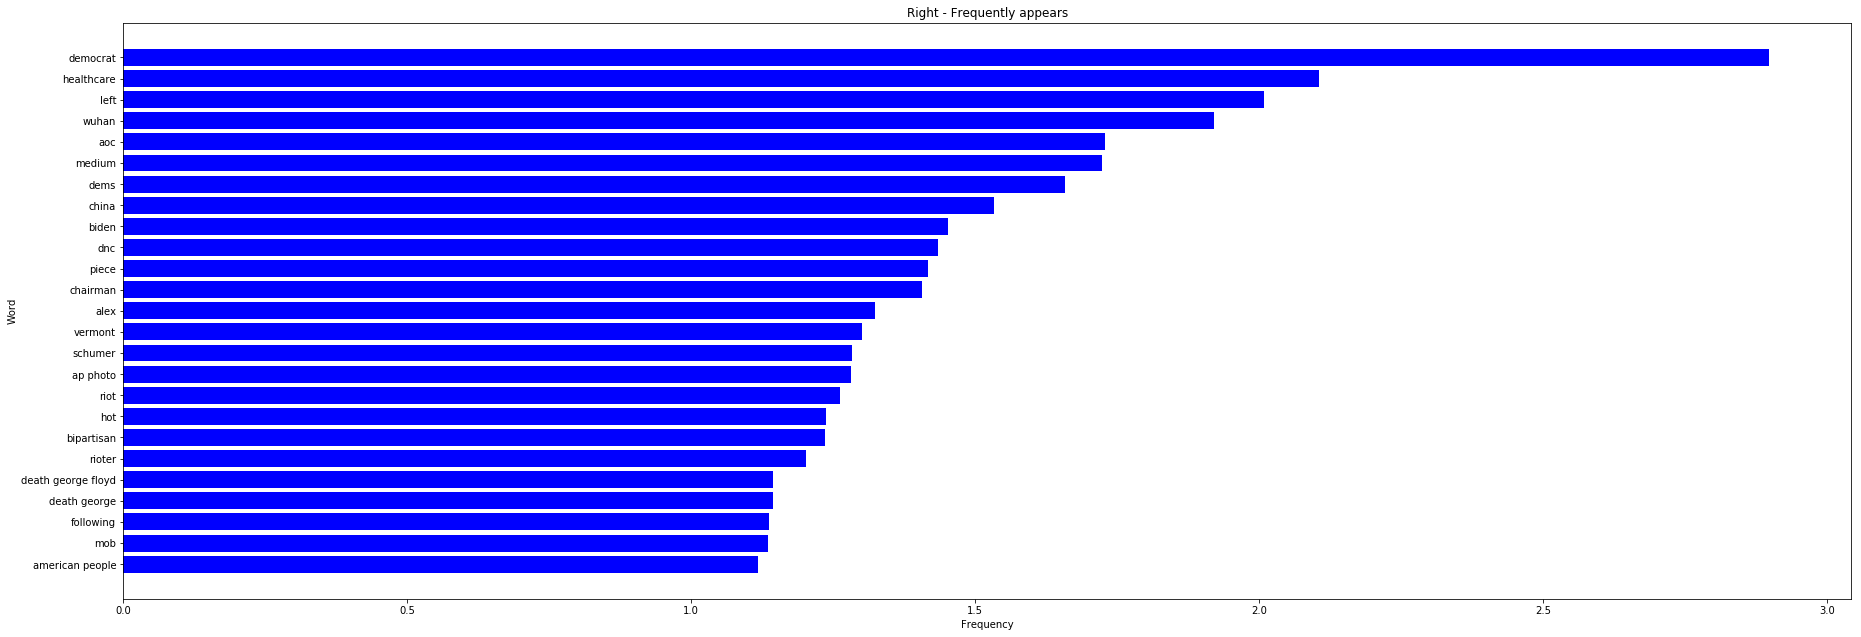

In [60]:
# Plot the most frequently occurring words seen in text labelled as right or left
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def plot_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.bar(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Left - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.barh(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Left - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.bar(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Right - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.barh(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Right - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
plot_most_informative_features(count_vect, clf, 25)

In [61]:
#print(count_vect.get_feature_names())

In [62]:
# Let's save our model
#joblib.dump(text_clf, 'pipeline.pkl')

Confusion Matrix:
[[2832  117]
 [  67 2882]]
Accuracy Score : 0.9688029840623941
Report : 
              precision    recall  f1-score   support

       Right       0.98      0.96      0.97      2949
        Left       0.96      0.98      0.97      2949

    accuracy                           0.97      5898
   macro avg       0.97      0.97      0.97      5898
weighted avg       0.97      0.97      0.97      5898

             Confusion Matrix


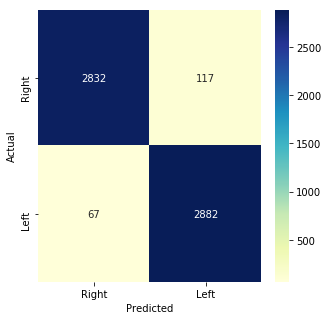

Classification Error of: 0.031197015937605967
95% Confidence Interval of: [0.026760133223869925, 0.03563389865134201]
Left = 0, Right = 1 

Predicted: 0 Actual: 1
OPINION: Shut The Freezer And Get Back To Work, Nancy    House Speaker Nancy Pelosi of Calif., gestures for Democrats to stop talking during a vote on the articles of impeachment against President Donald Trump, Wednesday, Dec. 18, 2019, on Capitol Hill in Washington. (AP Photo/Patrick Semansky) When President Trump announced Wednesday he was considering using an obscure Constitutional provision to adjourn Congress so he could make recess appointments he felt necessary to help address the current COVID-19 crisis, I couldn’t help but wonder if Trump’s true aim with that political arrow was House Speaker Nancy Pelosi’s heart as she sat unsuspecting in her California kitchen, enjoying expensive ice cream far away from Washington DC. Because while Trump’s frustration sounded like it was a result of Senate inaction on appointments 

Highest performing classifier: Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 2), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('eclf',
                 VotingClassifier(estimators=[('svc',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0))),
                                              ('sgd',
                                               CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=0))),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=200,
                                                                      random_state=0))],
                                  voting='soft'))])


In [63]:
# End Results - Load the model and let's see the end results
text_clf = joblib.load('hsr_and_nrw_bigram_sr_l_nopr.pkl')
predicted = text_clf.predict(all_data.unfiltered_articles)
#print(metrics.classification_report(test.pole, predicted, target_names=["NotSpam", "Spam"]))
tn, fp, fn, tp = metrics.confusion_matrix(all_data.pole, predicted).ravel()
results = metrics.confusion_matrix(all_data.pole, predicted)
#print((tn, fp, fn, tp))
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', metrics.accuracy_score(all_data.pole, predicted))
print('Report : ')
print(metrics.classification_report(all_data.pole, predicted, target_names=["Right", "Left"]))


print("             Confusion Matrix")
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(results, annot=True, fmt='d', cmap='YlGnBu',
           xticklabels=["Right","Left"], yticklabels=["Right","Left"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Error
incorrect_predictions = fp + fn
total_predictions = tp + tn + fp + fn
classification_error = incorrect_predictions / total_predictions
print("Classification Error of:",classification_error)

# 95% Confidence Interval (const: 1.96)
# There is a 95% likelihood that the confidence interval [0.xx, 0.xx] 
# covers the true classification error of the model on unseen data.
confidence_interval = []
confidence_interval.append(classification_error - 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
confidence_interval.append(classification_error + 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
print("95% Confidence Interval of:",confidence_interval)

# Let's see some examples of how the model and original dataset is classifying text.
print("Left = 0, Right = 1 \n")
for x in range(5):
    print("Predicted:", predicted[x], end=" ")
    print("Actual:", all_data['pole'][x])
    print(all_data['unfiltered_articles'][x], end="\n\n")

print("Highest performing classifier:", text_clf)

In [64]:
# Write results to results.txt for the entire notebook's run.
acc = metrics.accuracy_score(all_data.pole, predicted)
acc = "Entire dataset accuracy: " + str(acc) + "\n"
f = open('results.txt', 'a+')
f.write(acc)
f.close()

In [72]:
for model, acc in final_model:
    print(acc)

0.8405367231638419
0.8557909604519774
0.8678248587570622
0.8741525423728813
0.6440395480225989
0.7417231638418077
0.8659887005649718
0.8777966101694916


In [73]:
for x in range(len(final_model)):
    print(final_model[x])

[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', AdaBoostClassifier(random_state=0))]), 0.8405367231638419]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=0))]), 0.8557909604519774]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0)))]), 0.8678248587570622]
[Pipeline(steps=[('vect',
   

In [75]:
print(text_clf)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('eclf',
                 VotingClassifier(estimators=[('svc',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0))),
                                              ('sgd',
                                               CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=0))),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=200,
                                                                      random_state=0))],
                                  voting='soft'))])
